In [1]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler

## charger les données

In [2]:
data = pd.read_csv("preprocess_table.csv")

## classe déséquilibrée

In [3]:
# Séparer les caractéristiques (X) et les étiquettes (y)
X = data.drop(columns=['TARGET'])
y = data['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 282682, 1: 24825})


In [4]:
X.shape

(307507, 774)

### traitement des données

In [5]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
counter = Counter(y_train)
print(counter)



## configurer ML_flow

In [ ]:
#définition du serveur de suivi mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")  #équivalent à http://localhost:5000
# le lancer sur un prompt : mlflow server --host 127.0.0.1 --port 5000

### score

In [ ]:
# Définir la fonction de coût
def cost_function(y_true, y_pred_prob, threshold, cost_fn=10, cost_fp=1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fn * cost_fn) + (fp * cost_fp)
    return cost

In [12]:
'''experiment_name="P7_score_cost"
mlflow.set_experiment(experiment_name)'''

<Experiment: artifact_location='mlflow-artifacts:/597761251475126147', creation_time=1738935086267, experiment_id='597761251475126147', last_update_time=1738935086267, lifecycle_stage='active', name='P7_score_cost', tags={}>

## ligthGBM

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [ ]:
# Paramètres du modèle
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': 10,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}


gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])




In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "LightGBM")

    
    # Prédire les probabilités
    y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # Calculer l'AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, gbm.predict(X_train))
    mlflow.lightgbm.log_model(gbm, "LGBM", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LGBM_total")

In [ ]:
model_uri

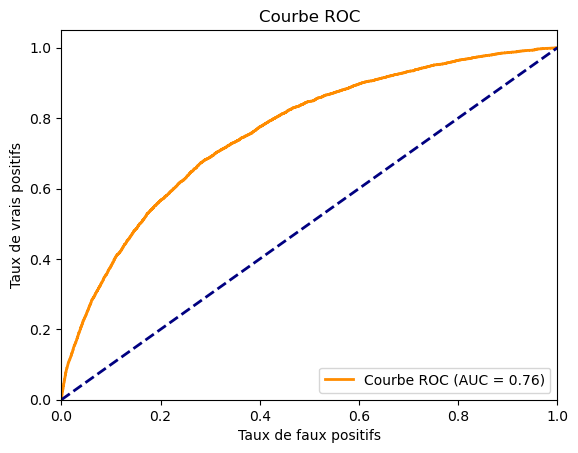

In [15]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### optimisation lgbm

In [16]:
# Créer un pipeline avec SMOTE et LightGBM
pipeline = imbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('lgbm', lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', random_state=42))
])

In [28]:


# Définir les hyperparamètres à tester
param_grid = {
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__num_leaves': [31, 50],
    'lgbm__max_depth': [10, 20],
    'lgbm__min_child_samples': [20, 30],
    'lgbm__feature_fraction': [0.8, 1.0],
    'lgbm__bagging_fraction': [0.8, 1.0],
    'lgbm__bagging_freq': [5, 10],
    'lgbm__reg_alpha': [0.1, 0.5],
    'lgbm__reg_lambda': [0.1, 0.5],
    'lgbm__scale_pos_weight': [1, 10]  # Utiliser scale_pos_weight pour gérer le déséquilibre

}    


#### learning rate

In [18]:
param_grid_lr = {
    'lgbm__learning_rate': [0.01, 0.1]
}

In [19]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_lr, cv=3, scoring='roc_auc', n_jobs=2)


In [20]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.614934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__learning_rate': 0.1}


In [29]:
param_grid.update(grid_search.best_params_)

In [30]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': [31, 50],
 'lgbm__max_depth': [10, 20],
 'lgbm__min_child_samples': [20, 30],
 'lgbm__feature_fraction': [0.8, 1.0],
 'lgbm__bagging_fraction': [0.8, 1.0],
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### num leaves

In [31]:
param_grid_nl = {
    'lgbm__num_leaves': [31, 50]
}

In [32]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_nl, cv=3, scoring='roc_auc', n_jobs=2)


In [33]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.616300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__num_leaves': 50}


In [34]:
param_grid.update(grid_search.best_params_)

In [35]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': [10, 20],
 'lgbm__min_child_samples': [20, 30],
 'lgbm__feature_fraction': [0.8, 1.0],
 'lgbm__bagging_fraction': [0.8, 1.0],
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### max depth

In [36]:
param_grid_md = {
    'lgbm__max_depth': [10, 20],
}

In [37]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_md, cv=3, scoring='roc_auc', n_jobs=2)


In [38]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.543244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__max_depth': 10}


In [39]:
param_grid.update(grid_search.best_params_)

In [40]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': [20, 30],
 'lgbm__feature_fraction': [0.8, 1.0],
 'lgbm__bagging_fraction': [0.8, 1.0],
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### min child samples

In [41]:
param_grid_mcs = {
    'lgbm__min_child_samples': [20, 30]
}

In [42]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_mcs, cv=3, scoring='roc_auc', n_jobs=2)


In [43]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.762989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__min_child_samples': 30}


In [44]:
param_grid.update(grid_search.best_params_)

In [45]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': [0.8, 1.0],
 'lgbm__bagging_fraction': [0.8, 1.0],
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### bagging fraction

In [46]:
param_grid_bf = {
    'lgbm__bagging_fraction': [0.8, 1.0]
}

In [47]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_bf, cv=3, scoring='roc_auc', n_jobs=2)


In [48]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.471646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__bagging_fraction': 0.8}


In [49]:
param_grid.update(grid_search.best_params_)

In [50]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': [0.8, 1.0],
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### feature fraction

In [51]:
param_grid_ff = {
    'lgbm__feature_fraction': [0.8, 1.0]
}

In [52]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_ff, cv=3, scoring='roc_auc', n_jobs=2)


In [53]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.788717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__feature_fraction': 0.8}


In [54]:
param_grid.update(grid_search.best_params_)

In [55]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': [5, 10],
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### bagging freq

In [56]:
param_grid_bfr = {
    'lgbm__bagging_freq': [5, 10]
}

In [57]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_bfr, cv=3, scoring='roc_auc', n_jobs=2)


In [58]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.639938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__bagging_freq': 5}


In [59]:
param_grid.update(grid_search.best_params_)

In [60]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': 5,
 'lgbm__reg_alpha': [0.1, 0.5],
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### reg alpha

In [61]:
param_grid_ra = {
    'lgbm__reg_alpha': [0.1, 0.5]
}

In [62]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_ra, cv=3, scoring='roc_auc', n_jobs=2)


In [63]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.597892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__reg_alpha': 0.5}


In [64]:
param_grid.update(grid_search.best_params_)

In [65]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': 5,
 'lgbm__reg_alpha': 0.5,
 'lgbm__reg_lambda': [0.1, 0.5],
 'lgbm__scale_pos_weight': [1, 10]}

#### reg lambda

In [66]:
param_grid_rl = {
    'lgbm__reg_lambda': [0.1, 0.5]
}

In [67]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_rl, cv=3, scoring='roc_auc', n_jobs=2)


In [68]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.789866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__reg_lambda': 0.5}


In [69]:
param_grid.update(grid_search.best_params_)

In [70]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': 5,
 'lgbm__reg_alpha': 0.5,
 'lgbm__reg_lambda': 0.5,
 'lgbm__scale_pos_weight': [1, 10]}

#### pos weight

In [71]:
param_grid_pw = {
    'lgbm__scale_pos_weight': [1, 10]
}

In [72]:


# Configurer GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid_pw, cv=3, scoring='roc_auc', n_jobs=2)


In [73]:
# Effectuer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.394709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174903
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs paramètres trouvés : {'lgbm__scale_pos_weight': 1}


In [74]:
param_grid.update(grid_search.best_params_)

In [75]:
param_grid

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': 5,
 'lgbm__reg_alpha': 0.5,
 'lgbm__reg_lambda': 0.5,
 'lgbm__scale_pos_weight': 1}

In [76]:
# Enregistrer les meilleurs paramètres
best_params =  param_grid

In [77]:
best_params

{'lgbm__learning_rate': 0.1,
 'lgbm__num_leaves': 50,
 'lgbm__max_depth': 10,
 'lgbm__min_child_samples': 30,
 'lgbm__feature_fraction': 0.8,
 'lgbm__bagging_fraction': 0.8,
 'lgbm__bagging_freq': 5,
 'lgbm__reg_alpha': 0.5,
 'lgbm__reg_lambda': 0.5,
 'lgbm__scale_pos_weight': 1}

In [78]:
# Entraîner le modèle final avec les meilleurs paramètres

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

gbm = lgb.train(best_params, train_data, num_boost_round=100, valid_sets=[test_data])

[LightGBM] [Warning] Unknown parameter: lgbm__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbm__min_child_samples
[LightGBM] [Warning] Unknown parameter: lgbm__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbm__max_depth
[LightGBM] [Warning] Unknown parameter: lgbm__feature_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__scale_pos_weight
[LightGBM] [Warning] Unknown parameter: lgbm__bagging_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__bagging_freq
[LightGBM] [Warning] Unknown parameter: lgbm__reg_lambda
[LightGBM] [Warning] Unknown parameter: lgbm__reg_alpha
[LightGBM] [Warning] Unknown parameter: lgbm__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbm__min_child_samples
[LightGBM] [Warning] Unknown parameter: lgbm__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbm__max_depth
[LightGBM] [Warning] Unknown parameter: lgbm__feature_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__scale_pos_weight
[LightGBM] [Warning] Unknown parameter:

In [79]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    #  Enregistrer les paramètres du modèle
    mlflow.log_params(best_params)
    mlflow.log_param("model_type", "LightGBM")

    # Prédire les probabilités
    y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # Calculer l'AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, gbm.predict(X_train))
    mlflow.lightgbm.log_model(gbm, "LGBM", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LGBM_optim")

Successfully registered model 'LGBM_optim'.
2025/02/21 16:27:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM_optim, version 1


🏃 View run sneaky-gnat-790 at: http://127.0.0.1:5000/#/experiments/597761251475126147/runs/d509763ed4ce43b4a3e93f3b47e4ea9e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/597761251475126147


Created version '1' of model 'LGBM_optim'.


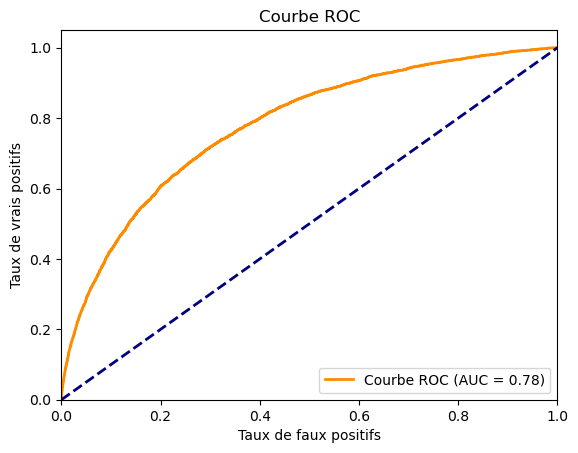

In [80]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

df : échantillon de montableau_entree
fonction = transform df ie lgb.dataset(df)
X =lgb.dataset(df)
curl api.request(X)
dans l'API request

## feature importance

In [85]:
X_test.shape

(61502, 774)

In [86]:
X_train.shape

(246005, 774)

In [83]:
import shap
# Utiliser SHAP pour l'importance des caractéristiques

explainer = shap.Explainer(gbm, X_train, feature_perturbation='interventional')

shap_values = explainer(X_test, check_additivity=False)

# Visualiser l'importance des caractéristiques
shap.summary_plot(shap_values, X_test)

100%|===================| 61492/61502 [02:50<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.096610, while the model output was 0.118117. If this difference is acceptable you can set check_additivity=False to disable this check.

100%|===================| 61435/61502 [03:03<00:00]        

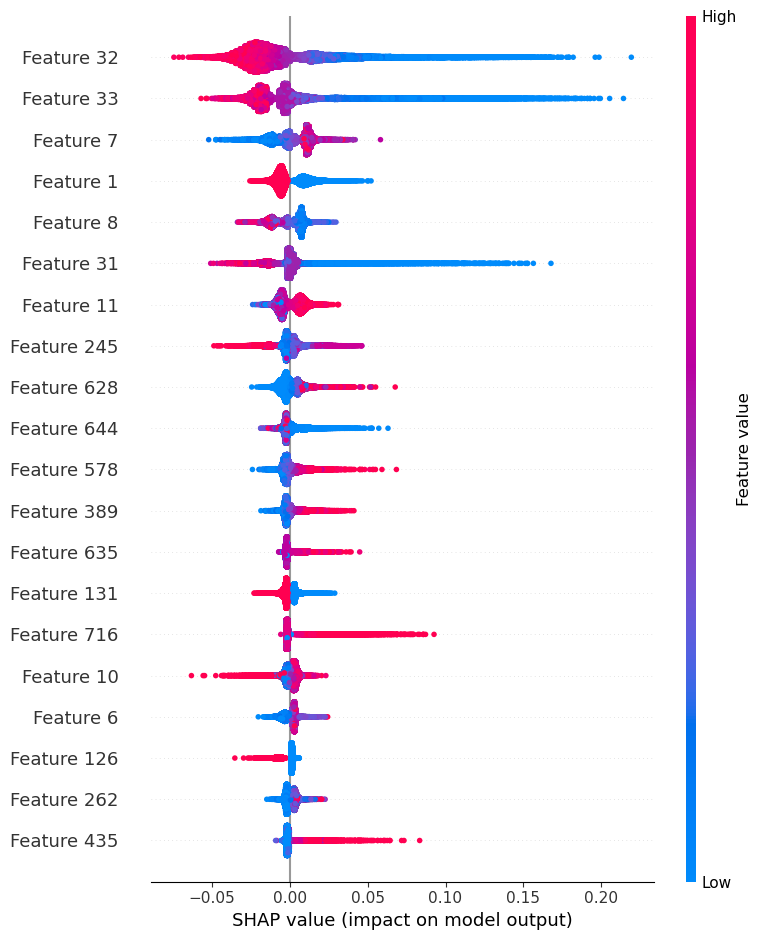

In [84]:
import shap
# Utiliser SHAP pour l'importance des caractéristiques

explainer = shap.Explainer(gbm, X_train, feature_perturbation='interventional')

shap_values = explainer(X_test, check_additivity=False)

# Visualiser l'importance des caractéristiques
shap.summary_plot(shap_values, X_test)